In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import ipywidgets as widgets
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import utils as utils
from scipy.stats import theilslopes
from ismn.interface import ISMN_Interface


%matplotlib inline

# Soil Moisture from Radiometer measurements

Satellite Radiometers measure emissions in various microwave frequency bands (Ku, X, C, L) from the Earth surface as brightness temperature. 

Brightness temperature (in degree Kelvin) is a function of kinetic temperature and emissivity. Wet soils have a higher emissivity than dry soils and therefore a higher brightness temperature. Passive soil moisture retrieval uses this difference between kinetic temperature and brightness temperature, to model the amount of water available in the soil of the observed area, while taking into account factors such as the water held by vegetation.

ESA's SMOS satellite is an example for an L-band radiometer mission.


In [2]:
smos = xr.open_dataset('./LTC_DATA/SMOS_LPRM_072021.nc')

slider=widgets.SelectionSlider(options=np.arange(1,31), value=1, description='July 2021:', continuous_update=False)
@widgets.interact(day=slider)
def plot_lprm(day):
    """
    Select and visualise C3S SM data at a given time
    """
    fig, axs = plt.subplots(1, 3, figsize=(18,3), subplot_kw={'projection': ccrs.Robinson()})
    p1 = smos['temperature'].sel(time=f'2021-07-{day}').plot(transform=ccrs.PlateCarree(), ax=axs[0], cmap=plt.get_cmap('hot_r'), vmin=274, vmax=320)
    p2 = smos['vod'].sel(time=f'2021-07-{day}').plot(transform=ccrs.PlateCarree(), ax=axs[1], cmap=plt.get_cmap('Greens'), vmin=0, vmax=0.5)
    p3 = smos['soil_moisture'].sel(time=f'2021-07-{day}').plot(transform=ccrs.PlateCarree(), ax=axs[2], cmap=utils.cm_sm, vmin=0, vmax=0.5)
            
    for p in [p1, p2, p3]:
        p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
        p.axes.coastlines()
        
    plt.tight_layout()
    

interactive(children=(SelectionSlider(continuous_update=False, description='July 2021:', options=(1, 2, 3, 4, …

# Soil Moisture from Scatterometer measurements

# Soil Moisture from Synthetic Aperture Radar measurements

# Merged Soil Moisture products: ESA CCI & C3S Soil Moisture

About the data

In [3]:
c3s_annual = xr.open_dataset('./LTC_DATA/C3S_v202012_COMBINED_annual.nc')

slider=widgets.SelectionSlider(options=np.arange(1991,2022), value=2021, description='Select a year:', continuous_update=False)
@widgets.interact(year=slider)
def plot_soil_moisture(year, Anomalies=False):
    """
    Select and visualise C3S SM data at a given time
    """
    if Anomalies:
        var = 'sm_anom'
        kwargs = dict(cmap=plt.get_cmap("RdBu"), vmin=-0.1, vmax=0.1)
    else:
        var = 'sm'
        kwargs = dict(cmap=utils.cm_sm, vmin=0, vmax=0.5)

    fig, axs = plt.subplots(1, 2, figsize=(18,5), subplot_kw={'projection': ccrs.Robinson()})
    p1 = c3s_annual[var].sel(year=year).plot(transform=ccrs.PlateCarree(), ax=axs[0], **kwargs)
    p2 = c3s_annual['nobs'].sel(year=year).plot(transform=ccrs.PlateCarree(), ax=axs[1], cmap=plt.get_cmap('YlGnBu'))
    
    for p in [p1, p2]:
        p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
        p.axes.coastlines()
        
    plt.tight_layout()

interactive(children=(SelectionSlider(continuous_update=False, description='Select a year:', index=30, options…

# Time Series Analysis

You can:
    - Choose a point (Longitude between -180 and 180 degrees, and Latitide between -60 and 90 degrees; point must be over land) to extract the data for
    - Choose a time interval to compute the trend for.

In [4]:
c3s = xr.open_dataset('./LTC_DATA/STACK_C3S-SOILMOISTURE_v202012_PASSIVE_MONTHLY.nc')

slider=widgets.IntRangeSlider(min=1979, max=2021, value=[2000, 2021], step=1, description='Time Range', continuous_update=False)

@widgets.interact_manual(period=slider, Longitude="8.625", Latitude="44.625")
def extract_ts(period, Longitude, Latitude):
    lon, lat = float(Longitude), float(Latitude)
    
    # Extract time series at location
    ts = c3s.sel(lon=lon, lat=lat, method='nearest').to_pandas() \
             .loc[f"{period[0]}-01-01":f"{period[1]}-12-31", ['sm']]
    
    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    map_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ts_ax = fig.add_subplot(gs[0, 1:])

    # Plot overview map
    map_ax.set_extent([lon-20, lon+20, lat-10, lat+10])
    map_ax.add_feature(cartopy.feature.LAND, zorder=0)
    map_ax.add_feature(cartopy.feature.BORDERS)
    map_ax.coastlines()
    map_ax.plot([lon], [lat], 'ro', transform=ccrs.PlateCarree())
    map_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    
    # compute trend
    medslope, medinter, _, _ = theilslopes(ts.resample('A').mean().bfill().ffill().values, alpha=0.9)
    ts['trend'] = medinter + np.arange(len(ts.index.values)) * (medslope / 12)
    
    # Plot time series
    ts['sm'].plot(style='-o', ax=ts_ax, label='soil moisture')
    ts['trend'].plot(style='-', color='red', ax=ts_ax, label=f'{medslope:.4f} [m³/m³/year]')
    ts_ax.set_xlabel('Time [Year]')
    ts_ax.set_ylabel('SM $[m³/m³]$')
    ts_ax.set_title('Soil Moisture and Trend')
    ts_ax.legend()


interactive(children=(IntRangeSlider(value=(2000, 2021), continuous_update=False, description='Time Range', ma…

# Decomposition

This example we extract a time series of monthly average soil moisture conditions for a point in North-West Italy (Lon: 8.625, Lat: 44.635). These observations come from the PASSIVE only product of C3S Soil Moisture.

We then compute the average soil moisture conditions for each month within the selected reference period (**Climatology**). The deviation from this climatological reference are the soil moisture **Anomalies**. In addition we compute the long-term change in soil moisture (**Trend**) in this time series over the chosen period.

You can: 

    1) Change the baseline period to see how it affects the climatology computation and its effect on the derived anomalies.

In [5]:
data = pd.read_csv("./LTC_DATA/C3S_PASSIVE_TS_ITALY_8_625_44_625.csv", index_col=0, parse_dates=True)

slider=widgets.IntRangeSlider(min=1991, max=2021, value=[1991, 2020], step=1, description='Baseline:', continuous_update=True)
@widgets.interact(baseline=slider)
def plot_components(baseline):
    fig, axs = plt.subplots(3, 1, figsize=(7, 7))
    
    ts = data.copy().loc['1991-01-01':,:]
    
    clim_data = ts['sm'].loc[f'{baseline[0]}-01-01':f'{baseline[1]}-12-31'].rolling(3, min_periods=1).mean()
    clim_mean = pd.Series(clim_data.groupby(clim_data.index.month).mean(), name='climatology').rolling(3, min_periods=1).mean()
    
    ts = ts.join(on=ts.index.month, other=clim_mean)
    ts['anomaly'] = ts['sm'] - ts['climatology']
    
    ts['sm'].plot(ax=axs[0], title=f'Soil Moisture (absolute)', ylabel='SM $[m³/m³]$', xlabel='Time [Year]')
    for i, g in clim_data.groupby(clim_data.index.year):
        axs[1].plot(range(1,13), g.values, alpha=0.1)
    clim_mean.plot(ax=axs[1], color='blue', title='Climatology', ylabel='SM $[m³/m³]$', xlabel='Time [Month]')
    
    
    axs[2].axhline(0, color='k')
    axs[2].fill_between(ts['anomaly'].index,ts['anomaly'].values,where=ts['anomaly'].values>=0, color='blue')
    axs[2].fill_between(ts['anomaly'].index,ts['anomaly'].values,where=ts['anomaly'].values<0, color='red')
    axs[2].set_ylabel('SM $[m³/m³]$')
    axs[2].set_xlabel('Time [Year]')
    axs[2].set_title("SM Anomalies")
    plt.tight_layout()



interactive(children=(IntRangeSlider(value=(1991, 2020), description='Baseline:', max=2021, min=1991), Output(…

In [6]:
mask = xr.open_dataset('./grid.nc')['country'].sortby('lat', ascending=False)
lut = dict(zip(mask.attrs['flag_meanings'], mask.attrs['flag_values']))

def load_study_area(country, var='sm', time_from='2010-01-01'):
    subset = c3s.sel(time=slice(time_from, None))[var]
    sel = mask.where(mask==lut[country], drop=True)
    subset = subset.sel(lat=sel.lat, lon=sel.lon)
    subset.values[:, ~np.isfinite(sel)] = np.nan
    return subset


In [7]:
subset_anom = load_study_area('Italy', var='sm_anom')

slider=widgets.SelectionSlider(options=np.arange(2010,2022), value=2021, description='Select a year:', continuous_update=False)
@widgets.interact(year=slider)
def plot_months(year=2021):
    dat = subset_anom.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))
    p = dat.plot(transform=ccrs.PlateCarree(),
                 col='time', col_wrap=6, vmin=-0.2, vmax=0.2, cmap=plt.get_cmap('RdBu'),
                 subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in p.axs.flat:
        ax.axes.add_feature(cartopy.feature.BORDERS, linewidth=0.5, zorder=2)        
        ax.axes.coastlines()


interactive(children=(SelectionSlider(continuous_update=False, description='Select a year:', index=11, options…

# In situ soil moisture

Found existing ismn metadata in LTC_DATA/insitu/python_metadata/insitu.csv.


<AxesSubplot: title={'center': 'Insitu data at STEMS network (0-0.1 m depth'}, xlabel='time', ylabel='SM [m³/m³]'>

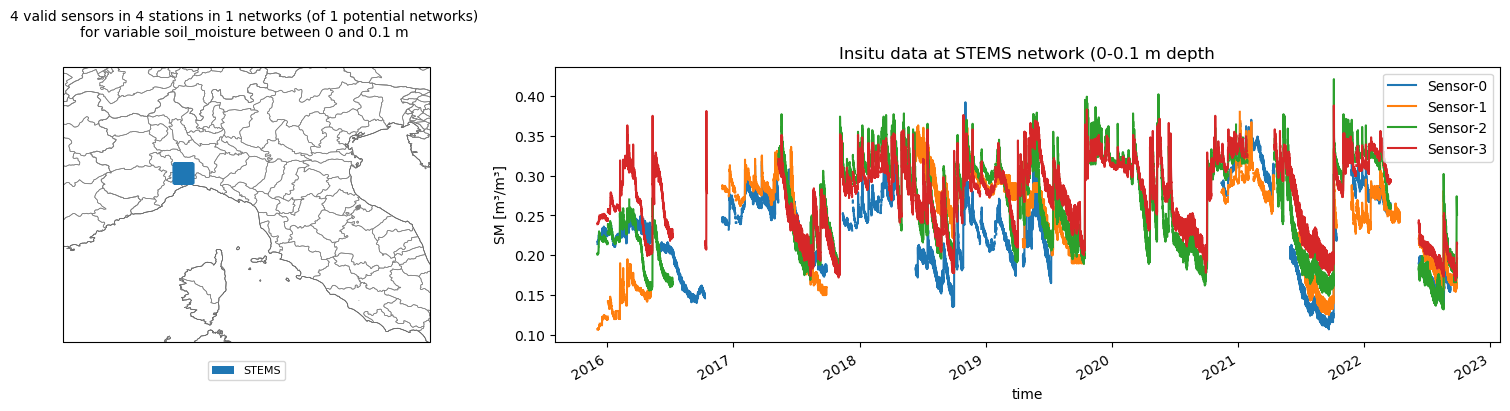

In [8]:
ismn = ISMN_Interface("./LTC_DATA/insitu")
min_depth, max_depth = 0, 0.1

fig = plt.figure(figsize=(15,4), constrained_layout=True)
gs = fig.add_gridspec(1, 3)
map_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ts_ax = fig.add_subplot(gs[0, 1:])
    
ismn.plot_station_locations(variable='soil_moisture', min_depth=min_depth, max_depth=max_depth, markersize=15, text_scalefactor=2, ax=map_ax)
map_ax.set_extent([6,14,41,47])

sensors = []
i = 0
for network, station, sensor in ismn.collection.iter_sensors(variable='soil_moisture', depth=(min_depth, max_depth)):
    data = sensor.read_data()
    data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
    data = data['soil_moisture']
    data.name = f"Sensor-{i}"
    sensors.append(data)
    i += 1
    
df = pd.concat(sensors, axis=1)
df.plot(ax=ts_ax, xlabel='time', ylabel='SM [m³/m³]', title=f'Insitu data at STEMS network ({min_depth}-{max_depth} m depth')


We check how the insitu time series correlate with each other

<AxesSubplot: >

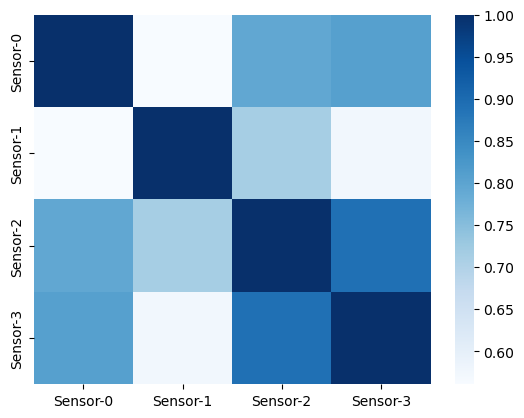

In [9]:
import seaborn as sns
sns.heatmap(df.corr(), cmap=plt.get_cmap('Blues'))

In [10]:
df.mean().diff()

Sensor-0         NaN
Sensor-1    0.010592
Sensor-2    0.023455
Sensor-3    0.011473
dtype: float64